# Deep Learning

<a target="_blank" href="https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch10-deeplearning-lab.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intro-stat-learning/ISLP_labs/v2.2?labpath=Ch10-deeplearning-lab.ipynb)

In this section we  demonstrate how to fit the examples discussed
in the text. We use the `Python`{} `torch` package, along with the
`pytorch_lightning` package which provides utilities to simplify
fitting and evaluating models.  This code can be impressively fast
with certain  special processors,  such as Apple’s new M1 chip. The package is well-structured, flexible, and will feel comfortable
to `Python`{} users. A good companion is the site
[pytorch.org/tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html).
Much of our code is adapted from there, as well as the `pytorch_lightning` documentation. {The precise URLs at the time of writing are <https://pytorch.org/tutorials/beginner/basics/intro.html> and <https://pytorch-lightning.readthedocs.io/en/latest/>.}

We start with several standard imports that we have  seen before.

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

### Torch-Specific Imports
There are a number of imports for `torch`. (These are not
included with `ISLP`, so must be installed separately.)
First we import the main library
and essential tools used to specify sequentially-structured networks.

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset


There are several other helper packages for `torch`. For instance,
the `torchmetrics` package has utilities to compute
various metrics to evaluate performance when fitting
a model. The `torchinfo` package provides a useful
summary of the layers of a model. We use the `read_image()`
function when loading test images in Section~\ref{Ch13-deeplearning-lab:using-pretrained-cnn-models}.

If you have not already installed the packages `torchvision`
and `torchinfo` you can install them by running
`pip install torchinfo torchvision`.
We can now import from `torchinfo`.


In [3]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary


The package `pytorch_lightning` is a somewhat higher-level
interface to `torch` that simplifies the specification and
fitting of
models by reducing the amount of boilerplate code needed
(compared to using `torch` alone).

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger


In order to reproduce results we use `seed_everything()`. We will also instruct `torch` to use deterministic algorithms
where possible.

In [5]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


Seed set to 0


We will use several datasets shipped with `torchvision` for our
examples: a pretrained network for image classification,
as well as some transforms used for preprocessing.

In [6]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

We have provided a few utilities in `ISLP` specifically for this lab.
The `SimpleDataModule` and `SimpleModule` are simple
versions of objects used in `pytorch_lightning`, the
high-level module for fitting `torch` models. Although more advanced
uses such as computing on graphical processing units (GPUs) and parallel data processing
are possible in this module, we will not be focusing much on these
in this lab. The `ErrorTracker` handles
collections of targets and predictions over each mini-batch
in the validation or test stage, allowing computation
of the metric over the entire validation or test data set.

In [7]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)


In addition we have included some helper
functions to load the
`IMDb` database, as well as a lookup that maps integers
to particular keys in the database. We’ve included
a slightly modified copy of the preprocessed
`IMDb` data from `keras`, a separate package
for fitting deep learning models. This saves us significant
preprocessing and allows us to focus on specifying and fitting
the models themselves.

In [8]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)


Finally, we introduce some utility imports  not directly related to
`torch`.
The `glob()` function from the `glob` module is used
to find all files matching wildcard characters, which we will use
in our example applying the `ResNet50` model
to some of our own images.
The `json` module will be used to load
a JSON file for looking up classes to identify the labels of the
pictures in the `ResNet50` example.

In [9]:
from glob import glob
import json


In [10]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

## IMDB Document Classification
We now implement models for sentiment classification (Section~\ref{Ch13:sec:docum-class})  on the `IMDB`
dataset. As mentioned above code block~8, we are using
a preprocessed version of the `IMDB` dataset found in the
`keras` package. As `keras` uses `tensorflow`, a different
tensor and deep learning library, we have
converted the data to be suitable for `torch`. The
code used to convert from `keras` is
available in the module `ISLP.torch._make_imdb`. It
requires some of the `keras` packages to run. These data use a dictionary of size 10,000.

We have stored three different representations of the review data for this lab:

* `load_tensor()`, a sparse tensor version usable by `torch`;
* `load_sparse()`, a sparse matrix version usable by `sklearn`, since we will compare with a lasso fit;
* `load_sequential()`, a padded
version of the original sequence representation, limited to the last
500 words of each review.



In [11]:
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]


/Users/qiu.yang/anaconda3/envs/islp/lib/python3.10/site-packages/ISLP/torch/imdb.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S_test) = [torch.load(_get_imdb(f'IMDB

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

The datasets `imdb_seq_train` and `imdb_seq_test` are
both instances of the class `TensorDataset`. The
tensors used to construct them can be found in the `tensors` attribute, with
the first tensor  the features `X` and the second  the outcome `Y`.
We have taken the first row of features and stored it as `padded_sample`. In the preprocessing
used to form these data, sequences were padded with 0s in the beginning if they were
not long enough, hence we remove this padding by restricting to entries where
`padded_sample > 0`. We then provide the first 12 words of the sample review.

We can find these words in the `lookup` dictionary from the `ISLP.torch.imdb` module.

In [12]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

For our first model, we have created a binary feature for each
of the 10,000 possible words in the dataset, with an entry of one
in the $i,j$ entry if word $j$ appears in review $i$. As most reviews
are quite short, such a feature matrix has over 98% zeros. These data
are accessed using `load_tensor()` from the `ISLP` library.

In [13]:
max_num_workers=10
(imdb_train,
 imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)


/Users/qiu.yang/anaconda3/envs/islp/lib/python3.10/site-packages/ISLP/torch/imdb.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test, X_train = [torch.load(_get_imd

We’ll use a two-layer model for our first model.

In [14]:
class IMDBModel(nn.Module):

    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)


We now instantiate our model and look at a summary.

In [15]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (G): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

We’ll again use
a smaller learning rate for these data,
hence we pass an `optimizer` to the
`SimpleModule`. 
Since the reviews are classified into
positive or negative sentiment, we use
`SimpleModule.binary_classification()`. {Our use of
  `binary_classification()` instead of  `classification()` is
  due to some subtlety in how `torchmetrics.Accuracy()` works,
as well as the data type of the targets.}

In [16]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)


Having loaded the datasets into a data module
and created a `SimpleModule`, the remaining steps
are familiar.

In [17]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/Users/qiu.yang/anaconda3/envs/islp/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=30` reached.


Evaluating the test error yields roughly 86% accuracy.

In [18]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8501200079917908
        test_loss            1.086783766746521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.086783766746521, 'test_accuracy': 0.8501200079917908}]

### Comparison to Lasso
We now fit a lasso logistic regression model
 using `LogisticRegression()` from `sklearn`. Since `sklearn` does not recognize
the sparse tensors of `torch`, we use a sparse
matrix that is recognized by `sklearn.`

In [19]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000,
                                 random_state=0,
                                 root='data/IMDB')


Similar to what we did in
Section~\ref{Ch13-deeplearning-lab:single-layer-network-on-hitters-data},
we construct a series of 50 values for the lasso reguralization parameter $\lambda$.

In [20]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))


With `LogisticRegression()` the regularization parameter
$C$ is specified as the inverse of $\lambda$. There are several
solvers for logistic regression; here we use `liblinear` which
works well with the sparse input format. 

In [21]:
logit = LogisticRegression(penalty='l1', 
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)


The path of 50 values takes approximately 40 seconds to run.

In [22]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)


The coefficient and intercepts have an extraneous dimension which can be removed
by the `np.squeeze()`  function.

In [23]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)


We’ll now make a plot to compare our neural network results with the
lasso.

In [24]:
%%capture
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)


Notice the use of `%%capture`, which suppresses the displaying of the partially completed figure. This is useful
when making a complex figure, since the steps can be spread across two or more cells.
We now add a plot of the lasso accuracy, and display the composed figure by simply entering its name at the end of the cell.

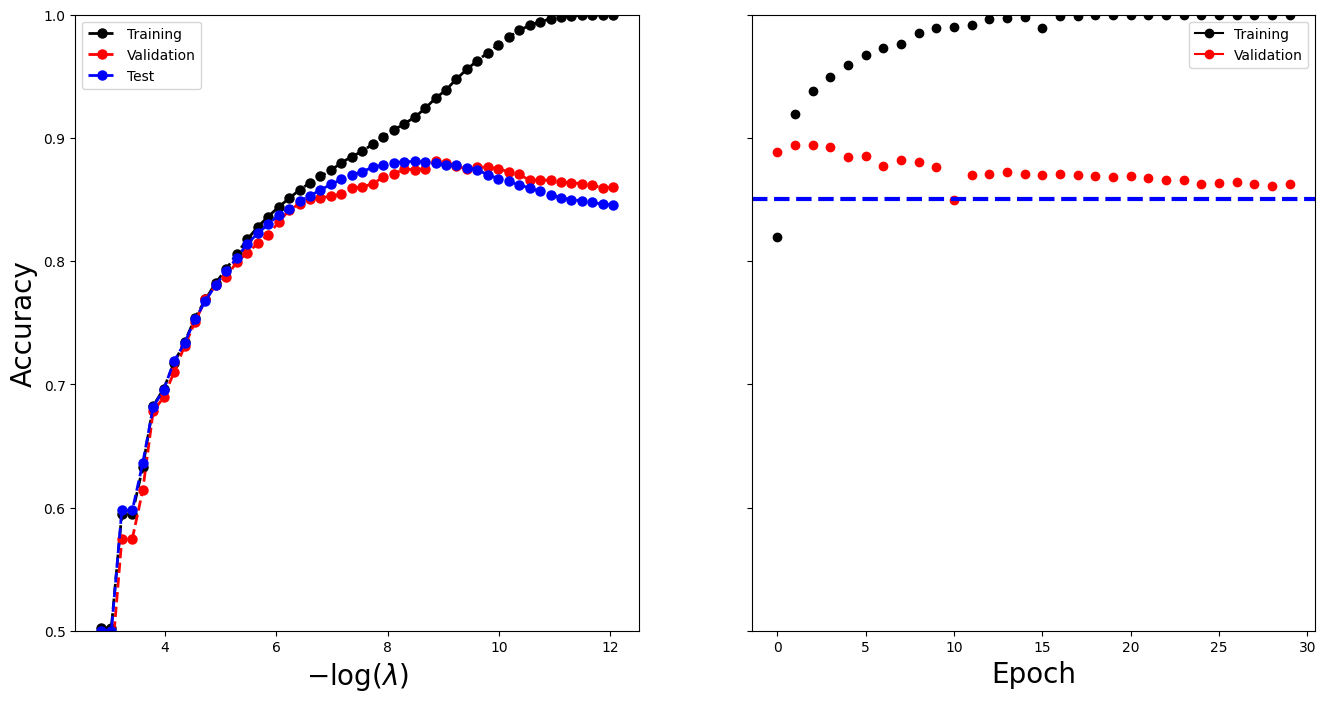

In [25]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

From the graphs we see that the accuracy of the lasso logistic regression peaks at about $0.88$,  as it does for  the neural network.

Once again, we end with a cleanup.

In [26]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

## Recurrent Neural Networks
In this lab we fit the models illustrated in
Section~\ref{Ch13:sec:recurr-neur-netw}.

### Sequential Models for Document Classification
Here we  fit a simple  LSTM RNN for sentiment prediction to
the `IMDb` movie-review data, as discussed in Section~\ref{Ch13:sec:sequ-models-docum}.
For an RNN we use the sequence of words in a document, taking their
order into account. We loaded the preprocessed 
data at the beginning of
Section~\ref{Ch13-deeplearning-lab:imdb-document-classification}.
A script that details the preprocessing can be found in the
`ISLP` library. Notably, since more than 90% of the documents
had fewer than 500 words, we set the document length to 500. For
longer documents, we used the last 500 words, and for shorter
documents, we padded the front with blanks.


In [27]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers)
                               )


The first layer of the RNN is an embedding layer of size 32, which will be
learned during  training. This layer one-hot encodes  each document
as a matrix of dimension $500 \times 10,003$, and then maps these
$10,003$ dimensions down to $32$. {The extra 3 dimensions
correspond to commonly occurring non-word entries in the reviews.}
 Since each word is represented by an
integer, this is effectively achieved by the creation of an embedding
matrix of size $10,003\times 32$; each of the 500 integers in the
document are then mapped to the appropriate 32 real numbers by
indexing the appropriate rows of this matrix.

The second  layer is an LSTM with 32 units, and the output
layer is a single logit for the binary classification task.
In the last line of the `forward()` method below,
we take the last 32-dimensional output of the LSTM and map it to our response.

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True)
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

We instantiate and take a look at the summary of the model, using the
first 10 documents in the corpus.

In [29]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (M): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

The 10,003 is suppressed in the summary, but we see it in the
parameter count, since $10,003\times 32=320,096$.

In [30]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')


In [31]:
lstm_trainer = Trainer(deterministic=True,
                       max_epochs=20,
                       logger=lstm_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


The rest is now similar to other networks we have fit. We
track the test performance as the network is fit, and see that it attains 85% accuracy.

In [32]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8545600175857544
        test_loss            0.713660478591919
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.713660478591919, 'test_accuracy': 0.8545600175857544}]

We once again show the learning progress, followed by cleanup.

(0.5, 1.0)

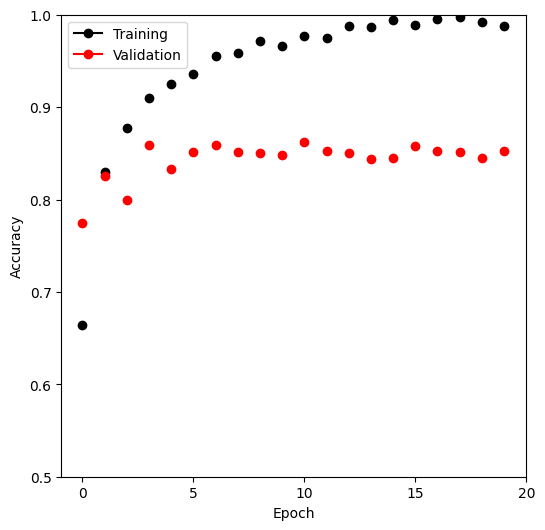

In [33]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])


In [34]:
del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)


### Time Series Prediction
We now show how to fit the models in Section~\ref{Ch13:sec:time-seri-pred}
for  time series prediction.
We first load and standardize the data.

In [35]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                     with_mean=True,
                     with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)


Next we set up the lagged versions of the data, dropping
any rows with missing values using the `dropna()`  method.

In [36]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()


Finally, we extract the response, training indicator, and drop the current day’s `DJ_return` and
`log_volatility` to predict only from previous day’s data.

In [37]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns


Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

We first fit a simple linear model and compute the $R^2$ on the test data using
the `score()`  method.

In [38]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

We refit this model, including the factor variable `day_of_week`.
For a categorical series in `pandas`, we can form the indicators
using the `get_dummies()`  method.

In [39]:
X_day = pd.concat([X, 
                  pd.get_dummies(NYSE['day_of_week'])],
                  axis=1).dropna()

 Note that we do not have
to reinstantiate the linear regression model
as its `fit()` method accepts a design matrix and a response directly.

In [40]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053273

This model achieves an $R^2$ of about 46%.

To fit the RNN, we must reshape the data, as it will expect 5 lagged
versions of each feature as indicated by the  `input_shape` argument
to the layer `nn.RNN()`  below. We first
ensure the columns of  our data frame are such that a reshaped
matrix will have the variables correctly lagged. We use the
`reindex()`  method to do this.

For an input shape `(5,3)`, each row represents a lagged version of the three variables.
The `nn.RNN()` layer also expects the first row of each
observation to be earliest in time, so we must reverse the current order.  Hence we loop over
`range(5,0,-1)` below, which is
an example of using a  `slice()`  to index
iterable objects. The general notation is `start:end:step`. 

In [41]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns


Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

We now reshape the data.

In [42]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

By specifying the first size as -1, `numpy.reshape()` deduces its size based on the remaining arguments.

Now we are ready to proceed with the RNN, which uses 12 hidden units, and  10%
dropout.
After passing through the RNN,  we extract the final time point as `val[:,-1]`
in `forward()` below. This gets passed through a 10% dropout and then flattened through
a linear layer.

In [43]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.

We form the training dataset similar to
our `Hitters` example.

In [44]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets


/var/folders/r1/fldnbcxn6l184n5x4ymxcmlh0000gn/T/ipykernel_40374/3890359531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
/var/folders/r1/fldnbcxn6l184n5x4ymxcmlh0000gn/T/ipykernel_40374/3890359531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


Following our usual pattern, we inspect the summary.

In [45]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

We again put the two datasets into a data module, with a
batch size of 64.

In [46]:
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

We run some data through our model to be sure the sizes match up correctly.

In [47]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


We follow our previous example for setting up a trainer for a
regression problem, requesting the $R^2$ metric
to be be computed at each epoch.

In [48]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})


Fitting the model should by now be familiar.
The results on the test data are very similar to the linear AR model. 

In [49]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/qiu.yang/anaconda3/envs/islp/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.61750328540802
         test_r2             0.413959264755249
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.61750328540802, 'test_r2': 0.413959264755249}]

We could also fit a model without the `nn.RNN()` layer by just
using a `nn.Flatten()` layer instead. This would be a nonlinear AR model. If in addition we excluded the 
hidden layer, this would be equivalent to our earlier linear AR model.  

Instead we will fit a nonlinear AR model using the feature set `X_day` that includes the `day_of_week` indicators.
To do so, we
must first create our test and training datasets and a corresponding
data module. This may seem a little burdensome, but is part of the
general pipeline for `torch`.

In [50]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                   np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

Creating a data module follows a familiar pattern.

In [51]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)


We build a `NonLinearARModel()` that takes as input the 20 features and a hidden layer  with 32 units. The remaining steps are familiar.

In [52]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))


In [53]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                           lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                        optimizer=nl_optimizer,
                                        metrics={'r2':R2Score()})


We continue with the usual training steps, fit the model,
and evaluate the test error. We see the test $R^2$ is a slight improvement over the linear AR model that also includes `day_of_week`.

In [54]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     enable_progress_bar=False,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5637862682342529
         test_r2            0.4649393558502197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5637862682342529, 'test_r2': 0.4649393558502197}]